## Cloning Git Repository :

In [1]:
%%capture
!git clone https://github.com/TheoBacqueyrisse/Graph-Neural-Networks.git

In [1]:
# Install dependencies
%%capture
!pip install -r requirements.txt

UsageError: Line magic function `%%capture` not found.


In [3]:
# Import Packages
import torch
import torch_geometric
from torch_geometric.datasets import ZINC
import networkx as nx
import matplotlib.pyplot as plt

## Load ZINC Dataset ⏳

In [6]:
zinc = ZINC('/workspaces/data')

Extracting /workspaces/data/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 7445.42it/s]
Done!


## Investigation of the Data  🔎

In [16]:
print("General info on the Data : ")
print(30*'-')
print("Number of features in the Data : ", zinc.num_features)
print("Number of Graphs : ", zinc.len)
print("Example : ", zinc[0])

General info on the Data : 
------------------------------
Number of features in the Data :  1
Number of Graphs :  <bound method InMemoryDataset.len of ZINC(220011)>
Example :  Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])


In [8]:
ex = zinc[0]
ex

Data(x=[33, 1], edge_index=[2, 72], edge_attr=[72], y=[1])

In [9]:
#
ex.x

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [2],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [5]])

In [10]:
# The Edge Indexes show what Nodes Interact with each other
ex.edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 6, 32],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 8, 31],
        [ 9,  8],
        [ 9, 10],
        [ 9, 11],
        [10,  9],
        [11,  9],
        [11, 12],
        [11, 28],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [13, 27],
        [14, 13],
        [14, 15],
        [14, 16],
        [15, 14],
        [16, 14],
        [16, 17],
        [16, 25],
        [17, 16],
        [17, 18],
        [17, 23],
        [18, 17],
        [18, 19],
        [19, 18],
        [19, 20],
        [20, 19],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [23, 17],
        [23, 22],
        [23, 24],
        [24, 23],
        [2

In [11]:
ex.edge_attr

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1])

In [12]:
# That is our target variable, the Penalized logP
ex.y

tensor([3.0464])

We can create a function designed to plot a visual representation of a graph from the ZINC dataset, given its index.

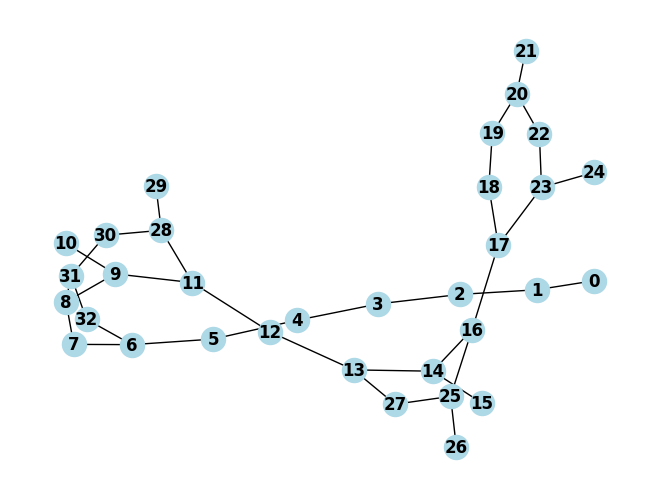

In [13]:
def graph_representation(index_zinc):
  G = nx.Graph()

  # Add nodes to the graph plot
  for i in range(zinc[index_zinc].num_nodes):
      G.add_node(i)

  # Add edges to the NetworkX graph
  edge_index = zinc[index_zinc].edge_index.t().numpy()
  edges = [(edge[0], edge[1]) for edge in edge_index]
  G.add_edges_from(edges)

  return G


nx.draw(graph_representation(0), with_labels=True, node_color='lightblue', font_weight='bold')

However, we see here a property of graphs, that is the change in their structure


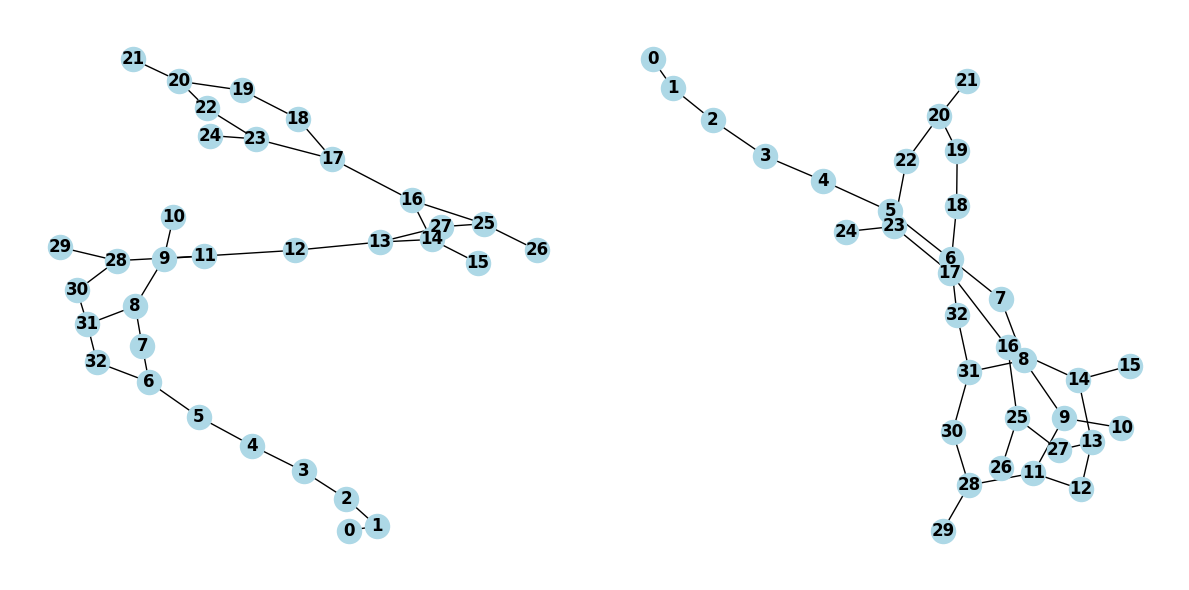

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(graph_representation(0), with_labels=True, node_color='lightblue', font_weight='bold')

plt.subplot(1, 2, 2)
nx.draw(graph_representation(0), with_labels=True, node_color='lightblue', font_weight='bold')

plt.tight_layout()
plt.show()